# Introduction

In this project, I will analyze the relation between the price of UK houses, the amount of room, location, and the date of purchase. To get a reliable analysis, we will use the dataset for recent 3 years (2018 - 2020).

In [185]:
import requests
import pandas as pd
import os
import numpy as np
from bs4 import BeautifulSoup
pd.options.mode.chained_assignment = None  # default='warn'

# Download the UK house price dataset from API

This dataset has a very huge size (about 200MB for a year) that we must seperate the dataset month by month.

In [ ]:
URL = "https://landregistry.data.gov.uk/app/ppd/ppd_data.csv?et%5B%5D=lrcommon%3Afreehold&et%5B%5D=lrcommon%3Aleasehold" \
      "&limit=all&max_date=&min_date=&nb%5B%5D=true&nb%5B%5D=false&ptype%5B%5D=lrcommon%3Adetached&" \
      "ptype%5B%5D=lrcommon%3Asemi-detached&ptype%5B%5D=lrcommon%3Aterraced&ptype%5B%5D=lrcommon%3Aflat-maisonette&ptyp" \
      "e%5B%5D=lrcommon%3AotherPropertyType&tc%5B%5D=ppd%3AstandardPricePaidTransaction&tc%5B%5D=ppd%3AadditionalPriceP" \
      "aidTransaction"

thirty = [4, 6, 9, 11]
thirty_one = [1, 3, 5, 7, 8, 10, 12]
leap = [2000, 2004, 2008, 2012, 2016, 2020]


def download(min_date, max_date):
    url = URL.replace("min_date=", "min_date=" + min_date)
    url = url.replace("max_date=", "max_date=" + max_date)
    print("Downloading： " + min_date + "_" + max_date + ".csv")
    r = requests.get(url)
    with open(".\\" + min_date + "_" + max_date + ".csv", "wb") as file:
        file.write(r.content)


def min_date_generate(y, m):
    if y >= 10:
        int_year = int("20" + str(y))
    else:
        int_year = int("200" + str(y))

    str_year = str(int_year)
    if m >= 10:
        min_date = str_year + "-" + str(m) + "-01"
    else:
        min_date = str_year + "-0" + str(m) + "-01"
    return min_date


def max_date_generate(y, m):
    if y >= 10:
        int_year = int("20" + str(y))
    else:
        int_year = int("200" + str(y))

    str_year = str(int_year)
    if m in thirty:
        if m >= 10:
            max_date = str_year + "-" + str(m) + "-30"
        else:
            max_date = str_year + "-0" + str(m) + "-30"
    elif m in thirty_one:
        if m >= 10:
            max_date = str_year + "-" + str(m) + "-31"
        else:
            max_date = str_year + "-0" + str(m) + "-31"
    else:
        if int_year in leap:
            max_date = str_year + "-0" + str(m) + "-29"
        else:
            max_date = str_year + "-0" + str(m) + "-28"
    return max_date

# y stand for year
# m stand for month
for y in range(17, 21):
    for m in range(1, 13):
        download(min_date_generate(y, m), max_date_generate(y, m))
print("Done")

# Webcrawling the room info dataset from Zoopla

The UK goverment only provides the price, very detailed address, and purchase date of houses, thus we need to obtain the amount of room for each house in the UK house price dataset. Zoopla has provided the amount of room for some houses that might included in the UK house price dataset, thus we can webcrawling the needed data from Zoopla.

Here, we import the UK house price datasets and merge them to one.

In [108]:
header_list = ["ID", "Price", "Date", "Postcode", "Property type", "New build",
               "Estate type", "SAON", "PAON", "Street", "Locality",
               "District", "Town", "County", "Transaction category", "Website"]
files = os.listdir('./')
dfs = []
for file in files:
    if ".csv" in file:
        df = pd.read_csv(os.path.abspath("./" + file), names=header_list)
        dfs.append(df)
df = pd.concat(dfs, axis=0, ignore_index=True)

However, the dataset is too huge that it could take months even if we use multithread to gather the data. Thus, we need to use random sample with dataframe for a reliable amount of data.

In [ ]:
df = df.sample(24000, random_state=1) # seed = 1
df.sort_index()

It is possible that some rows contains NaN in County column, which need to be dropped.

In [23]:
# Drop useless column for address dataframe
df_address = df.drop(columns=["ID", "New build", "Property type", "Estate type", "Date",
                              "Price", "Transaction category", "Website", "Town"])

# Drop the same row in df_address
df_address = df_address[df_address["County"].isnull() == False]
df_address = df_address[df_address["Postcode"].isnull() == False]

In [24]:
# Export the csv for future uses
df_address.to_csv("./address.csv")

In [147]:
df_address = pd.read_csv("./address.csv", index_col=0)
df_address

,Postcode,SAON,PAON,Street,Locality,District,County
1411449,NN18 0QT,NaN,18,LOWRY CLOSE,NaN,CORBY,NORTHAMPTONSHIRE
1405363,ME17 4QU,NaN,10,ADAM CLOSE,COXHEATH,MAIDSTONE,KENT
3738994,E17 5ES,NaN,90,FLEEMING ROAD,WALTHAMSTOW,LONDON,GREATER LONDON
2916886,WV7 3PX,NaN,3,BARCLAY CLOSE,ALBRIGHTON,WOLVERHAMPTON,SHROPSHIRE
1993268,SP8 4JS,NaN,24,ADDISON CLOSE,NaN,GILLINGHAM,DORSET
...,...,...,...,...,...,...,...
2786415,MK41 9DE,NaN,45,LEASWAY,NaN,BEDFORD,BEDFORD
52187,SA1 6HT,NaN,26,PENYGRAIG ROAD,TOWNHILL,SWANSEA,SWANSEA
3788842,TQ3 3QY,NaN,74,COLLEY END ROAD,NaN,PAIGNTON,TORBAY
3173169,BN16 2TR,NaN,27,THE ROYSTONS,EAST PRESTON,LITTLEHAMPTON,WEST SUSSEX


Now we can extract the postcode from UK house price dataset to obtain the room info.

In [271]:
# Define a url request function
def get_url_content(postcode, page):
    postcode = postcode.replace(' ', '-')
    url = 'http://www.zoopla.co.uk/house-prices/stalbans/cottonmill-lane/' + postcode + '/' + "?pn=" + str(page)
    data = requests.get(url, proxies={"http://": requests.get("http://localhost:5555/random").text.strip()})
    return data

In [272]:
# Define a function that can combine the value of columns to a string.
def to_string(df):
    string = ""
    if not str(df["SAON"]).upper() == "NAN":
        if df["SAON"].isdigit():
            string = string + df["SAON"] + " "
        else:
            string = string + df["SAON"] + " "
            
    if not str(df["PAON"]).upper() == "NAN":
        if " - " in df["PAON"]:
            df["PAON"] = df["PAON"].replace(" - ", "-")
        if df["PAON"].isdigit():
            string = string + df["PAON"] + " "
        else:
            string = string + df["PAON"] + " "
            
    if not str(df["Street"]).upper() == "NAN":
        string = string + df["Street"]
        
    string = string.replace(",", " ")
    string = string.replace("  ", " ")
    return string

Here, we use a multiprocessing to increase the speed of gathering. It will cost 30 hours if we use single process to gather the data. With 5 processes, the time will decrease to around 6 hours, so it is necessary to use a multiprocessing.

However, jupyter notebook cannot use multiprocessing, thus I gathered the data and exported the data into a csv.

Below is the code I used to gather the data.

In [ ]:
import time
import multiprocessing
import math

def gather(dataframe):
    print(multiprocessing.current_process().name)

    # Initialize page limit
    pages = 1

    # Loop until last page OR obtained the info for specific address
    for i in range(len(dataframe)):
        try:
            # Initialize the value per row
            bedroom = None
            bathroom = None
            reception = None
            wanted_address = to_string(dataframe.iloc[i])
            # print(wanted_address)
            found = False
            for j in range(1, pages + 1):
                # request data from website
                bs = BeautifulSoup(get_url_content(dataframe["Postcode"].iloc[i].replace(" ", "-"), j).content,
                                   "html.parser")

                # update page limit
                info = bs.find_all("div", {"class": "paginate bg-muted"})
                if len(info) == 1:
                    info = info[0].find_all("a")
                    if len(info) > 2:
                        pages = int(info[-2].text)

                room_info = bs.find_all("div", {"class": "hp-card-list"})

                if len(room_info) == 1:
                    room_info = room_info[0].find_all("section", {"class": "hp-card"})
                else:
                    break

                # Check if the address in this page
                for room in room_info:
                    searched_address = room.find("h3", {"class": "hp-card__title"}).string.strip().replace(",",
                                                                                                           "").upper()
                    # print(searched_address.replace(" " + dataframe["Postcode"].iloc[i], ""))
                    if wanted_address.strip() == searched_address.replace(" " + dataframe["Postcode"].iloc[i], ""):
                        print("Found")
                        # indicate room info found to exit traverse pages
                        found = True

                        # Bedroom
                        if room.find("li", {"class": "hp-card-room hp-card-room--bed"}) is not None:
                            bedroom = int(room.find("li", {"class": "hp-card-room hp-card-room--bed"})
                                          .text.replace("\n", "").replace("             ", "")
                                          .strip().replace("Bedrooms:", ""))

                        # Bathroom
                        if room.find("li", {"class": "hp-card-room hp-card-room--bath"}) is not None:
                            bathroom = int(room.find("li", {"class": "hp-card-room hp-card-room--bath"})
                                           .text.replace("\n", "").replace("             ", "")
                                           .strip().replace("Bathrooms:", ""))

                        # Reception
                        if room.find("li", {"class": "hp-card-room hp-card-room--recept"}) is not None:
                            reception = int(room.find("li", {"class": "hp-card-room hp-card-room--recept"})
                                            .text.replace("\n", "").replace("             ", "")
                                            .strip().replace("Reception rooms:", ""))
                        break

                # If room info found, find next room info.
                if found:
                    break

            dataframe.loc[dataframe.index[i], 'Bedroom'] = bedroom
            dataframe.loc[dataframe.index[i], 'Bathroom'] = bathroom
            dataframe.loc[dataframe.index[i], 'Reception'] = reception
            print(wanted_address)
            print(bedroom)
            print(bathroom)
            print(reception)
            print()
        except TypeError:
            dataframe.loc[dataframe.index[i], 'Bedroom'] = "fail"
            dataframe.loc[dataframe.index[i], 'Bathroom'] = "fail"
            dataframe.loc[dataframe.index[i], 'Reception'] = "fail"
    dataframe.to_csv("./dataset/" + str(dataframe.index[0]) + ".csv")

def split_df(df, num):
    df_list = []
    length = math.ceil(len(df_address) / num)
    for i in range(num):
        if i == 0:
            df_split = df.iloc[range(0, length)]
            df_list.append(df_split)
        elif i == num - 1:
            df_split = df.iloc[range(length * i, len(df))]
            df_list.append(df_split)
        else:
            df_split = df.iloc[range(length * i, length * (i + 1))]
            df_list.append(df_split)
    return df_list


if __name__ == '__main__':
    df_address = pd.read_csv("./address.csv", index_col=0)
    df_list = split_df(df_address, 100) # seperate the dataframe

    t1 = time.time()
    pool = multiprocessing.Pool(processes=5)

    pool.map(gather, df_list[:])
    print(time.time() - t1)       # It took about 6 hours to gather the data

    pool.close()
    pool.join()

# Merging both datasets

We will merge both datasets to obtain a dataset which has price, purchase of date, city, and amount of room for each house.

Now we need to read csv files which were output by the above code.

In [106]:
files = os.listdir('./dataset/')
dfs = []
for file in files:
    if ".csv" in file:
        df2 = pd.read_csv(os.path.abspath("./dataset/" + file), index_col=0)
        dfs.append(df2)
df_room = pd.concat(dfs, axis=0)

Now we can construct a df_price dataframe base on the df_address dataframe

In [143]:
# Construct a new Dataframe
df2 = pd.DataFrame(columns = header_list)

# Add three new columns
df2["Bedroom"] = None
df2["Bathroom"] = None
df2["Reception"] = None

# Assign row of df_room from original dataframe
for x in range(len(df)):
    if x in df_room.index:
        df2.loc[x] = df.loc[x]
        df2["Bedroom"].loc[x] = df_room["Bedroom"].loc[x]
        df2["Bathroom"].loc[x] = df_room["Bathroom"].loc[x]
        df2["Reception"].loc[x] = df_room["Reception"].loc[x]
        
# Export this dataframe for future use
df2.to_csv("./price_and_room.csv")

# Processing the dataset

Now we have all the information we need in this new dataframe - df2. Apparently, this dataset is not clean enough to perform visualization or use to train a model, so we need to clean this dataset first.

In [131]:
df2 = pd.read_csv("./price_and_room.csv", index_col=0)

# Drop rows that is not useful in our analysis.
df2 = df2.drop(columns=["ID", "Postcode", "New build", "SAON", "PAON", "Street", "District",
                        "Locality", "Town", "Transaction category", "Website"])

# Drop rows that NaN in more than 1 columns
df2 = df2[((df2["Bedroom"].isnull() == False) | (df2["Bathroom"].isnull() == False))
         &((df2["Bathroom"].isnull() == False)| (df2["Reception"].isnull() == False))
         &((df2["Bedroom"].isnull() == False) | (df2["Reception"].isnull() == False))]

df2 = df2[df2["Bedroom"] != 0]
df2 = df2[df2["Bathroom"] != 0]
df2 = df2[df2["Reception"] != 0]

df2

,Price,Date,Property type,Estate type,County,Bedroom,Bathroom,Reception
500,299999,2017-01-27,S,F,WEST MIDLANDS,3.0,1.0,2.0
1332,383000,2017-01-27,D,F,WORCESTERSHIRE,4.0,2.0,3.0
1807,90000,2017-01-27,T,F,STAFFORDSHIRE,2.0,1.0,1.0
1822,150000,2017-01-20,T,F,STAFFORDSHIRE,3.0,1.0,2.0
2667,215000,2017-01-20,S,F,SOMERSET,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...
3883889,320000,2020-12-08,T,F,STAFFORDSHIRE,3.0,2.0,2.0
3884058,165000,2020-12-18,S,F,WEST MIDLANDS,3.0,NaN,2.0
3884318,190000,2020-12-14,D,F,WEST MIDLANDS,3.0,1.0,2.0
3884552,750000,2020-12-11,D,F,STAFFORDSHIRE,6.0,NaN,3.0


Now we can identify how many rows that have NaN in room columns

In [132]:
print("NaN in Bedroom:", df2["Bedroom"].isnull().sum())
print("NaN in Bathroom:", df2["Bathroom"].isnull().sum())
print("NaN in Reception:", df2["Reception"].isnull().sum())

NaN in Bedroom: 0
NaN in Bathroom: 1336
NaN in Reception: 281


Bathroom have about 11% NaN, and Reception have about 2% NaN. Here we can assign an approximate value for both columns based on two other columns. For example, if Bathroom is NaN, Bedroom is 3, and Reception is 2. Then we can assign the most common bathroom value for bedroom is 3 and reception is 2.

In [133]:
for x in df2.index:
    if pd.isnull(df2["Bathroom"].loc[x]):
        df2["Bathroom"].loc[x] = df2["Bathroom"].groupby((df2["Bedroom"] == df2["Bedroom"].loc[x]) & 
                                                          (df2["Reception"] == df2["Reception"].loc[x])).mean().sort_index()[1]
    if pd.isnull(df2["Reception"].loc[x]):
        df2["Reception"].loc[x] = df2["Reception"].groupby((df2["Bedroom"] == df2["Bedroom"].loc[x]) & 
                                                            (df2["Bathroom"] == df2["Bathroom"].loc[x])).mean().sort_index()[1]
df2

,Price,Date,Property type,Estate type,County,Bedroom,Bathroom,Reception
500,299999,2017-01-27,S,F,WEST MIDLANDS,3.0,1.000000,2.0
1332,383000,2017-01-27,D,F,WORCESTERSHIRE,4.0,2.000000,3.0
1807,90000,2017-01-27,T,F,STAFFORDSHIRE,2.0,1.000000,1.0
1822,150000,2017-01-20,T,F,STAFFORDSHIRE,3.0,1.000000,2.0
2667,215000,2017-01-20,S,F,SOMERSET,3.0,2.000000,1.0
...,...,...,...,...,...,...,...,...
3883889,320000,2020-12-08,T,F,STAFFORDSHIRE,3.0,2.000000,2.0
3884058,165000,2020-12-18,S,F,WEST MIDLANDS,3.0,1.242503,2.0
3884318,190000,2020-12-14,D,F,WEST MIDLANDS,3.0,1.000000,2.0
3884552,750000,2020-12-11,D,F,STAFFORDSHIRE,6.0,3.036522,3.0


Now we can deal the row with abnormal prices to increase the accuracy of dataset. We will drop top 50 values and bottom 50 values to ensure the analysis would not be inaccurate.

In [134]:
df2.drop(index=df2.nlargest(50, 'Price').index, inplace=True)
df2.drop(index=df2.nsmallest(50, 'Price').index, inplace=True)

Also, we should consider that small value count is not reliable because the amount of sample are too few. Thus we also need to examine the value count of bedroom and drop rows if any of them has too few sample. 

In [135]:
print(df2["Bedroom"].value_counts())
print(df2["Bathroom"].value_counts())
print(df2["Reception"].value_counts())

3.0    5323
2.0    3147
4.0    1963
1.0     487
5.0     424
6.0      76
7.0      22
8.0       3
9.0       1
Name: Bedroom, dtype: int64
1.000000    7161
2.000000    2453
3.000000     425
1.229488     336
1.112534     256
1.242503     138
1.242503     119
1.774737      73
1.795349      70
4.000000      69
1.795349      65
1.137868      38
1.464865      28
2.193333      27
2.080702      26
2.080702      26
1.034739      21
1.034739      20
5.000000      18
1.137868      15
2.089286       9
2.474074       7
2.474074       5
3.036522       4
2.277778       4
6.000000       4
1.307692       4
2.089286       3
2.304348       3
1.692308       2
2.964286       2
2.888889       2
1.229488       2
1.774737       2
2.964286       1
2.913043       1
9.000000       1
7.000000       1
1.315789       1
2.200000       1
2.277778       1
1.692308       1
Name: Bathroom, dtype: int64
1.000000    6295
2.000000    3982
3.000000     766
4.000000     107
1.217267      68
1.490146      61
1.561786      26
1.

We can see that the amount of sample for bedroom > 5 or bathroom > 4 or Reception > 4 are too few, thus we need to drop them.

In [136]:
df2 = df2[df2["Bedroom"] < 5]
df2 = df2[df2["Bathroom"] < 4]
df2 = df2[df2["Reception"] < 4]

Now we can insert the days for visulization. Let's set the earliest date as 0, and assign value to other dates.

In [137]:
df2["Date"] = pd.to_datetime(df2["Date"])
df2["Month"] = None # Create a day column
for x in df2.index:
    df2["Month"].loc[x] = round((df2["Date"].loc[x] - df2["Date"].min()).days /30)  # A way to get approximate month

In [162]:
df2[df2["County"] == "OXFORDSHIRE"]["Price"].mean()

357254.34959349595

Let's see what locations distribute most of the trade.

In [139]:
df2["County"].value_counts()

GREATER LONDON            1031
GREATER MANCHESTER         528
WEST MIDLANDS              514
WEST YORKSHIRE             508
KENT                       308
                          ... 
MONMOUTHSHIRE               11
RUTLAND                      9
CEREDIGION                   6
WEST NORTHAMPTONSHIRE        1
NORTH NORTHAMPTONSHIRE       1
Name: County, Length: 114, dtype: int64

# Visualize to analyze the dataset

Since we already have a clean dataset, now we can perform a visualization to this dataset and analyze the relation between the price and other features of houses. We will observe the graph that indicate the relation between price and purchase date, price and location, price and amount of room.

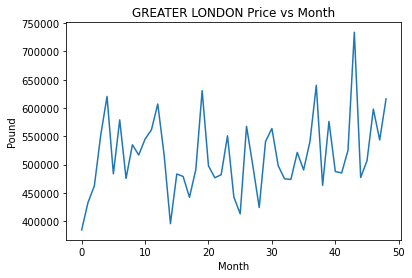

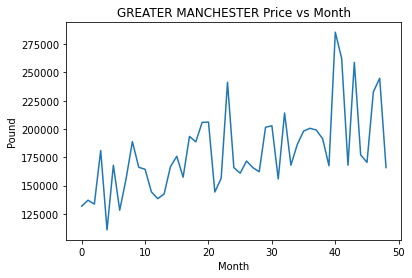

In [140]:
import matplotlib.pyplot as plt

# Price vs date in Greater London (mean)
plt.ticklabel_format(style='plain')
plt.xlabel("Month")
plt.ylabel("Pound")
plt.title("GREATER LONDON Price vs Month")
np.polyfit()
london = df2[df2["County"] == "GREATER LONDON"].groupby("Month")["Price"].mean()
london.plot.line()
plt.show()

# Price vs date in Greater Manchester (mean)
plt.ticklabel_format(style='plain')
plt.xlabel("Month")
plt.ylabel("Pound")

plt.title("GREATER MANCHESTER Price vs Month")
manchester = df2[df2["County"] == "GREATER MANCHESTER"].groupby("Month")["Price"].mean()
manchester.plot.line()
plt.show()

From above graphs, we can see that date indeed is a factor to affect the price of house, however, the importance of date is far less than the importance of location. You can see that the mean price of houses in Greater London is almost three times of the mean price of houses in Greater Manchester.

Now, let's see how the amount of rooms could affect the mean price of houses.

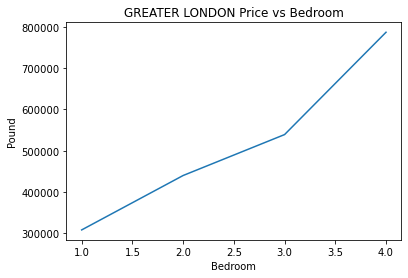

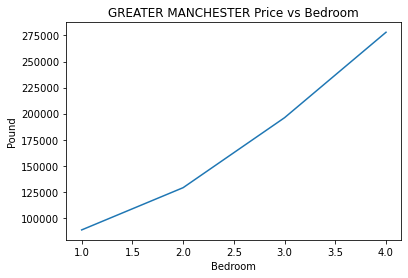

In [142]:
# Price vs amount of bedroom in Greater London(mean)
plt.ticklabel_format(style='plain')
plt.xlabel("Room")
plt.ylabel("Pound")
plt.title("GREATER LONDON Price vs Bedroom")
london = df2[df2["County"] == "GREATER LONDON"].groupby("Bedroom")["Price"].mean()
london.plot.line()
plt.show()

# Price vs amount of bedroom in Greater Manchester(mean)
plt.ticklabel_format(style='plain')
plt.xlabel("Room")
plt.ylabel("Pound")
plt.title("GREATER MANCHESTER Price vs Bedroom")
london = df2[df2["County"] == "GREATER MANCHESTER"].groupby("Bedroom")["Price"].mean()
london.plot.line()
plt.show()

We can see that the amount of bedroom is also an important factor that could affect the mean price of houses. The importance of the amount of bedroom is greater than the imporance of the date of purchase. However, from above graph, we can conclude that the location factor is still the most important factor that affect the mean price of houses.

# Train model to analyze the dataset

Training a model by the merged dataset can also help us understand the importance of each feature of houses by examine the coefficient of each feature of houses. In this step, we will build a KNN model and LinearRegression model to predict the price of houses.

Before we build the model, we need to transform the dataset again because values in location column are string that cannot simply use to train the model.

Now, we take a look on how many county exist, then indicate the county is a big city or not.

In [143]:
df2["County"].unique()

array(['WEST MIDLANDS', 'WORCESTERSHIRE', 'STAFFORDSHIRE', 'SOMERSET',
       'POOLE', 'DORSET', 'GREATER MANCHESTER', 'WEST SUSSEX',
       'GREATER LONDON', 'CITY OF BRISTOL', 'CUMBRIA', 'CAMBRIDGESHIRE',
       'BRIDGEND', 'RHONDDA CYNON TAFF', 'FLINTSHIRE', 'MERSEYSIDE',
       'ESSEX', 'KENT', 'WARWICKSHIRE', 'CHESHIRE EAST', 'DERBYSHIRE',
       'CITY OF DERBY', 'DARLINGTON', 'NORTH YORKSHIRE', 'COUNTY DURHAM',
       'SOUTH YORKSHIRE', 'NOTTINGHAMSHIRE', 'NORTH EAST LINCOLNSHIRE',
       'DEVON', 'BLACKPOOL', 'LANCASHIRE', 'GLOUCESTERSHIRE', 'SURREY',
       'HAMPSHIRE', 'WEST YORKSHIRE', 'HERTFORDSHIRE',
       'CITY OF KINGSTON UPON HULL', 'SUFFOLK', 'LEICESTERSHIRE',
       'LEICESTER', 'CONWY', 'CENTRAL BEDFORDSHIRE', 'MEDWAY',
       'NORTHUMBERLAND', 'TYNE AND WEAR', 'CITY OF NOTTINGHAM',
       'LINCOLNSHIRE', 'NORTHAMPTONSHIRE', 'NEWPORT', 'NORFOLK',
       'OXFORDSHIRE', 'CITY OF PETERBOROUGH', 'CORNWALL', 'PORTSMOUTH',
       'READING', 'WEST BERKSHIRE', 'BRACKNELL FOR

In [176]:
# Create Columns indicate the size of county
df2["BigCity"] = None
df2["NearBigCity"] = None
df2["MediumCity"] = None

df2.loc[(df2["County"] == "GREATER LONDON"), "BigCity"] = 1

df2.loc[(df2["County"] == "KENT")|
        (df2["County"] == "WEST SUSSEX")|
        (df2["County"] == "CAMBRIDGESHIRE")|
        (df2["County"] == "ESSEX")|
        (df2["County"] == "SURREY")|
        (df2["County"] == "HERTFORDSHIRE")|
        (df2["County"] == "MEDWAY")|
        (df2["County"] == "OXFORDSHIRE")|
        (df2["County"] == "READING")|
        (df2["County"] == "WEST BERKSHIRE")|
        (df2["County"] == "BRACKNELL FOREST")|
        (df2["County"] == "WOKINGHAM")|
        (df2["County"] == "EAST SUSSEX")|
        (df2["County"] == "BUCKINGHAMSHIRE")|
        (df2["County"] == "SLOUGH")|
        (df2["County"] == "WINDSOR AND MAIDENHEAD")|
        (df2["County"] == "THURROCK")|
        (df2["County"] == "LUTON"), "NearBigCity"] = 1

df2.loc[(df2["County"] == "GREATER MANCHESTER")|
        (df2["County"] == "WEST MIDLANDS")|
        (df2["County"] == "MERSEYSIDE")|
        (df2["County"] == "WEST YORKSHIRE"), "MediumCity"] = 1

df2 = df2.fillna(0)

Now we can build a model and train it with the dataset above.

In [217]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# We use half of the dataset as samples, and the rest of half to test the model.

df_train = df2.copy()
X_train = df_train.iloc[range(0, int(len(df_train)/2))]
X_train = X_train[["Bedroom", "Bathroom", "Reception", "Month", "BigCity", "NearBigCity", "MediumCity"]]
y_train = df_train.iloc[range(0, int(len(df_train)/2))]
y_train = y_train["Price"]

LR_model = LinearRegression()

KNN_model = make_pipeline(StandardScaler(),
                          KNeighborsRegressor(n_neighbors=5))

LR_model.fit(X=X_train, y=y_train)
print("Linear Regression Score:", np.mean(cross_val_score(LR_model, X=X_train, y=y_train, cv=10)))


KNN_model.fit(X=X_train, y=y_train)
print("KNN Score:", np.mean(cross_val_score(KNN_model, X=X_train, y=y_train, cv=10)))

Linear Regression Score: 0.49918490777185126
KNN Score: 0.4396713452926592


It seems that Linear Regression model has a better performance to predict the price of houses. Let's use some data from the rest of dataset to test the Linear Regression model.

In [215]:
X_test = df_train.iloc[range(int(len(df_train)/2), int(len(df_train)))]
X_test = X_test[["Bedroom", "Bathroom", "Reception", "Month", "BigCity", "NearBigCity", "MediumCity"]]
y_test = df_train.iloc[range(int(len(df_train)/2), int(len(df_train)))]
y_test = y_test["Price"]

y_pred = LR_model.predict(X_test)
print(y_pred)
print()
print(y_test)

[220760.42720109 133211.89117716 204488.97402899 ... 220820.46894187
 203339.07285183 432723.08380552]

1997532    135000
1998687     87000
1998767    195000
1998821     99000
1998840    230000
            ...  
3883565    299950
3883889    320000
3884058    165000
3884318    190000
3885721    380000
Name: Price, Length: 5406, dtype: int64


It seems that the model is not accurate enough to predict the price.
We can check the coefficient of the model to see if anything interest.

In [219]:
LR_model.coef_

array([ 54733.8592678 ,  72087.46276791,  32814.67675612,    522.15487203,
       318544.95530771, 141423.94166489, -30475.22615009])

From above coefficient, the model recognize that the main factor of mean price of houses is the location. Houses in London has extremely high price compare to the other location. Also, houses with its location near London also has a boost on its price. Besides, the amount of bedroom is less important than the amount of bathroom. Date of purchase take a very small portion of the mean price, however, it is still a important factor since 1 year could rise the mean price about 6264 pound.

# Conclusion

Location is the most important factor to the price of houses, and then the amount of rooms (size) of house is the second important factor to the price of house. The less important factor is the date of purchase, however, it still giving a positive effect to the price of house.